In [1]:
from tqdm.auto import tqdm
import numpy as np
import os, glob, pickle, json
import pandas as pd
from collections import Counter
import re, string
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
from collections import defaultdict, OrderedDict
import utils.score as evaluate
from scipy import stats


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package stopwords to /home/hemant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!ls data/3a/

bi_t.csv  lexicons	sentiment_test.csv   train_df.csv  val_df.csv
bi_v.csv  lexicons.zip	sentiment_train.csv  uni_t.csv
data.zip  npz		test_df.csv	     uni_v.csv


### preprocessing

In [3]:
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator) 

def prepr(txt):
    dummy = []
    for i in txt.split():
        if '@' in i: dummy.append('@someuser')
        elif '#' in  i: dummy.append('#someuser')
        elif i in stopwords: continue
        else: dummy.append(remove_punctuation(i))
    
    return dummy

### Naive bayes

In [4]:
class naive_bayes_():
    def __init__(self,train, test):
        self.train_x = [prepr(i.lower()) for i in tqdm(train['x'])]
        self.train_y = [i for i in tqdm(train['y'])]
        
        if test:
            self.test_x = [prepr(i.lower()) for i in tqdm(test['x'])]
            self.test_y = [i for i in tqdm(test['y'])]

            self.data_x, self.data_y = self.train_x + self.test_x, self.train_y + self.test_y
        
        else: 
            self.test_x = None
            self.data_x = self.train_x
            self.data_y = self.train_y 
        
        self.vocab = sorted([i for i in set([j for i in tqdm(self.data_x) for j in i])])
        
    def fit(self):
        
        dummy = Counter(self.train_y)
        prior = {i:dummy[i]/len(self.train_y) for i in set(dummy)}
        self.labels = prior.keys()

        matrix = {i:np.zeros(len(self.vocab)) for i in self.labels}
        self.vti = {i:d for d,i in enumerate(self.vocab)}
        
        dummy = {i:len(self.vocab) for i in self.labels}
        for i in tqdm(range(len(self.train_y))):
            count = Counter(self.train_x[i])
            dummy[self.train_y[i]] += sum(count.values())
            
            for k,v in count.items(): 
                matrix[self.train_y[i]][self.vti[k]]+= v
        
        for k,v in matrix.items():
            matrix[k] += 1
            matrix[k]/= dummy[k]
        
        self.prior = prior
        self.matrix = matrix
        self.dummy = dummy
        
        return prior, matrix
        
    def predict(self,test_x,pred=True):
        
        test_x = [' '.join(prepr(i.lower())) for i in test_x]
        pred_y = []

        for i in tqdm(test_x):
            label = {}
            for j in self.labels:
                prob = self.prior[j]
                for w in i.split():
                    if w in self.vti.keys(): prob *= self.matrix[j][self.vti[w]]
                    else: prob *= 1/(len(self.vocab) + self.dummy[j])
                label[j] = prob
#             pred_y.append(label)  
            a = sum(label.values())
            pred_y.append({k:v/a for k,v in label.items()})
        if pred: return [sorted(i.items(), key=lambda x:x[-1], reverse=True)[0][0] for i in pred_y]
        else: return pred_y


.

# 3A

In [5]:
# Dataset loading

train_3a = pd.read_csv('data/3a/sentiment_train.csv') # 11.2 lakhs
test_3a = pd.read_csv('data/3a/sentiment_test.csv') # 4.8 lakhs

dummy = False # Dummy data for testing

if not dummy:
    train = {
                'x': train_3a['5'],
                'y': train_3a['0']
    }

    test = {
                'x': test_3a['5'],
                'y': [i for i in test_3a['0']]
    }

else:
    train = {
                'x': ['chinese beijing chinese', 'chinese chinese shanghai', 'chinese macao','tokyo japan chinese'],
                'y': [1,1,1,2]
    }

    test = {
                'x': ['chinese chinese chinese tokyo japan', 'fuck this shit japan japan tokyo'],
                'y': [1,2]
    }

In [6]:
naive_bayes = naive_bayes_(train,None)
prior, matrix = naive_bayes.fit()

pred = naive_bayes.predict(test['x'], True)
assert len(pred) == len(test['y'])

# Evaluation

In [7]:
metric = evaluate.evaluate(test['y'], pred, naive_bayes.labels)
metric

macro prec and recall -- 0.7682886578859256 0.7681567907714086
 Macro F1 score: 0.7682227186698473
Accuracy: 0.7681166666666667


{'conf_labels': ['0', '4'],
 'conf_matrix': [[186640, 52564], [58740, 182056]],
 'macro_prec_and_rec': [0.7682886578859256, 0.7681567907714086],
 'macro_f1': 0.7682227186698473,
 'accuracy': 0.7681166666666667}

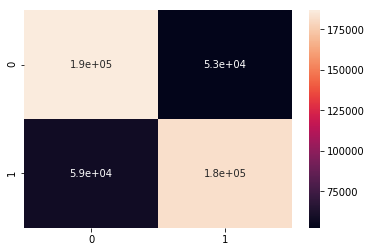

In [8]:
cm = metrics.confusion_matrix(test['y'], pred)
sns.heatmap(cm, annot=True)

# 3B

In [55]:
# Dataset loading

header_list = ['id', 'tweet', 'emo', 'intent']

df_train = pd.read_table('data/3b/train/out.txt', names=header_list)
train_x = [i for i in df_train['tweet']]
train_y = [i for i in df_train['emo']]

df_test = pd.read_table('data/3b/test/out.txt', names=header_list)
test_x = [i for i in df_test['tweet']]
test_y = [i for i in df_test['emo']]

train = {
                'x': train_x,
                'y': train_y
}

test = {
            'x': test_x,
            'y': [i for i in test_y]
}

In [56]:
naive_bayes = naive_bayes_(train,None)
prior, matrix = naive_bayes.fit()

pred = naive_bayes.predict(test['x'], True)
assert len(pred) == len(test['y'])

# Evaluation

In [57]:
metric = evaluate.evaluate(test['y'], pred, naive_bayes.labels)
metric

macro prec and recall -- 0.8145824894713771 0.8134398496240601
 Macro F1 score: 0.8140107685624898
Accuracy: 0.8120759837177748


{'conf_labels': ['anger', 'joy'],
 'conf_matrix': [[585, 175], [102, 612]],
 'macro_prec_and_rec': [0.8145824894713771, 0.8134398496240601],
 'macro_f1': 0.8140107685624898,
 'accuracy': 0.8120759837177748}

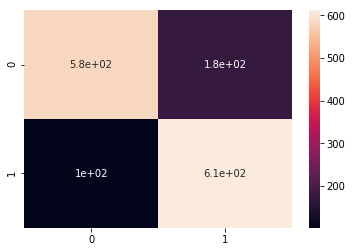

In [58]:
cm = metrics.confusion_matrix(test['y'], pred)
sns.heatmap(cm, annot=True)

## Pearson correlation

In [59]:
pred = naive_bayes.predict(test['x'], False)
pred = [sorted(i.items(), key=lambda x:x[-1], reverse=True)[0][-1] for i in pred]

test_ = [i for i in df_test['intent']]
stats.pearsonr(test_,pred)[0], stats.spearmanr(test_,pred)[0]

(-0.014455233629579787, 0.017891406897644083)

In [60]:
pred = naive_bayes.predict(test['x'], False)
pred = [sorted(i.items(), key=lambda x:x[-1], reverse=True)[0] for i in pred]

t_a, p_a = '', ''
for i in range(len(test_x)):
    t_a += f"{i}\t{test_x[i]}\t{df_test['emo'][i]}\t{df_test['intent'][i]}\n"
    p_a += f"{i}\t{test_x[i]}\t{pred[i][0]}\t{pred[i][1]}\n"

def save_(path, file):
    with open(path, "w") as f:
        f.write(file)
        
save_('true.txt', t_a)
save_('pred.txt', p_a)

!python2 eval.py 1 pred.txt true.txt


Pearson correlation between pred.txt and true.txt:	-0.014455233629579792
Spearman correlation between pred.txt and true.txt:	0.017891406897644083
Pearson correlation for gold scores in range 0.5-1 between pred.txt and true.txt:	0.025038320143194705
Spearman correlation for gold scores in range 0.5-1 between pred.txt and true.txt:	0.03419810852157647

Average Pearson correlation:	-0.014455233629579792
Average Spearman correlation:	0.017891406897644083
Average Pearson correlation for gold scores in range 0.5-1:	0.025038320143194705
Average Spearman correlationfor gold scores in range 0.5-1:	0.03419810852157647


.

.

.

# Feature implementation

### 3A

In [15]:
train = pd.concat([pd.read_csv("data/3a/train_df.csv"),pd.read_csv("data/3a/val_df.csv")],axis=0)[:40000]
val = pd.read_csv("data/3a/test_df.csv")
print(f"finish loading dataset")
axis = 1
print(train.shape)
train.dropna(axis=axis, inplace=True)
print(train.shape)
print(val.shape)
val.dropna(axis=axis, inplace=True)
print(val.shape)

finish loading dataset
(40000, 65)
(40000, 64)
(480000, 65)
(480000, 64)


In [16]:
train.drop(["tweets","Unnamed: 0"], axis = 1, inplace = True) 
val.drop(["tweets","Unnamed: 0"], axis = 1, inplace = True) 
[i for i in train.columns], [i for i in val.columns]

In [17]:
y_train = train['target']
train.drop(['target'], axis=1, inplace=True)
X_train = train

y_test = val['target']
val.drop(['target'], axis=1, inplace=True)
X_test = val

In [18]:
X_train.head(2)#, Counter(X_train['punctuation'])

elongated  p+  p-  p+-  punctu_1  punctu_2  allcaps  hashtag  negation  \
0          0   0   0    0         0         0        0        0         0   
1          0   0   0    0         0         0        0        0         0   

   nrc_emotion_score  ...  VBD  POS   EX   CD    #   DT   CC    ,  NNPS  VBZ  
0             -0.725  ...  0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0   0.0  0.0  
1             -2.648  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  

[2 rows x 61 columns]

In [19]:
X_test.head(2)#, Counter(X_test['punctuation'])

elongated  p+  p-  p+-  punctu_1  punctu_2  allcaps  hashtag  negation  \
0          0   0   0    0         4         1        0        0         0   
1          0   0   0    0         1         0        1        0         0   

   nrc_emotion_score  ...  VBD  POS   EX   CD    #   DT   CC    ,  NNPS  VBZ  
0              2.936  ...  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
1             -0.968  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  

[2 rows x 61 columns]

.

# PCA

In [20]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X_train)
sum(pca.explained_variance_ratio_)

0.9999999999076589

# Decions tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

# DT Classifier
dt = DecisionTreeClassifier()
# Lets fit the data into classifier 
dt.fit(X, y_train)

# predict on test data
y_pred = dt.predict(pca.transform(X_test))
out = evaluate.evaluate(y_test,y_pred,set(y_test))

import json
with open('dt.txt', "w") as f:
    f.write(json.dumps(out))

macro prec and recall -- 0.6220512392183131 0.622016631071002
 Macro F1 score: 0.6220339346632836
Accuracy: 0.62204375


# SVM

In [22]:
from sklearn.svm import SVC
# SVC Classifier
try: 
    with open("svm.pkl", "rb") as f:
        clf_SVC = pickle.load(f)
except: 
    print(f"training svc")
    clf_SVC = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
              probability=False, tol=0.001, cache_size=200, class_weight=None, 
              verbose=1, max_iter=-1, decision_function_shape="ovr", random_state = 0)

# Fitting training data
clf_SVC.fit(X,y_train)

# predictions
y_pred = clf_SVC.predict(pca.transform(X_test))
print('Test')
out = evaluate.evaluate(y_test,y_pred,set(y_test))

with open('svm.txt', "w") as f:
    f.write(json.dumps(out))
    

[LibSVM]Test
macro prec and recall -- 0.6530712098669329 0.5563107716563523
 Macro F1 score: 0.6008201780053161
Accuracy: 0.5549916666666667


In [23]:
with open('svm.pkl', "wb") as f:
    pickle.dump(clf_SVC,f)

# MLP

In [24]:
from sklearn.neural_network import MLPClassifier # neural network

# Classifier
clf = MLPClassifier(alpha=1e-4, hidden_layer_sizes=(32,16), random_state=1)
# print(clf.get_params())

#Fiting trainging data
clf.fit(X, y_train)

#predicting the data
y_pred = clf.predict(pca.transform(X_test))
print('Test')
out = evaluate.evaluate(y_test,y_pred,set(y_test))
with open('mlp.txt', "w") as f:
    f.write(json.dumps(out))

Test
macro prec and recall -- 0.5872993627426454 0.5851046049937395
 Macro F1 score: 0.5861999295585394
Accuracy: 0.5853666666666667


.

.

### 3B

In [25]:
train = pd.concat([pd.read_csv("data/3b/train_df_3B.csv"),pd.read_csv("data/3a/uni_t.csv")],axis=1)
val = pd.concat([pd.read_csv("data/3b/test_df_3B.csv"),pd.read_csv("data/3a/uni_v.csv")],axis=1)
print(f"finish loading dataset")
axis = 1
print(train.shape)
train.dropna(axis=axis, inplace=True)
print(train.shape)
print(val.shape)
val.dropna(axis=axis, inplace=True)
print(val.shape)

finish loading dataset
(1680, 4483)
(1680, 4483)
(1474, 4483)
(1474, 4483)


In [26]:
train.drop(["new_tweets","Unnamed: 0",'target'], axis = 1, inplace = True) 
val.drop(["new_tweets","Unnamed: 0",'target'], axis = 1, inplace = True) 
# [i for i in train.columns], [i for i in val.columns]

In [27]:
y_train = train['target_intensity']
train.drop(['target_intensity'], axis=1, inplace=True)
X_train = train

y_test = val['target_intensity']
val.drop(['target_intensity'], axis=1, inplace=True)
X_test = val

In [28]:
X_train.head(2)

vn     vp   vneu    comp  negation  pos_mpqa  neg_mpqa  pos_bilingu  \
0  0.0  0.352  0.648  0.5859         2         3         1            2   
1  0.0  0.352  0.648  0.5859         0         0         0            0   

   neg_bilingu  pos_sent140  ...  4439  4440  4441  4442  4443  4444  4445  \
0            1       136486  ...     0     0     0     0     0     0     0   
1            0       251709  ...     0     0     0     0     0     0     0   

   4446  4447  4448  
0     0     0     0  
1     0     0     0  

[2 rows x 4478 columns]

In [29]:
y_train.head(2)

0    0.438
1    0.583
Name: target_intensity, dtype: float64

## Decision tress


In [30]:
from sklearn.tree import DecisionTreeRegressor

# DT Classifier
dt = DecisionTreeRegressor(max_depth=3)
# Lets fit the data into classifier 
dt.fit(X_train, y_train)

# predict on test data
y_pred = dt.predict(X_test)

stats.pearsonr(y_test,y_pred)[0], stats.spearmanr(y_test,y_pred)[0]

(0.3195890686848026, 0.31243959423458206)

## SVM

In [31]:
from sklearn.svm import SVR

# SVC Classifier
clf_SVC = SVR(kernel='rbf', C=0.00001, gamma=0.08, epsilon=.05)

# Fitting training data
clf_SVC.fit(X_train,y_train)

# predictions
y_pred = clf_SVC.predict(X_test)

stats.pearsonr(y_test,y_pred)[0], stats.spearmanr(y_test,y_pred)[0]

(0.09158276228949125, 0.07832628291977015)

## MLP

In [32]:
from sklearn.neural_network import MLPRegressor # neural network

# Classifier
clf = MLPRegressor(alpha=1e-4, hidden_layer_sizes=(64,4), random_state=1, activation='relu')
# print(clf.get_params())

#Fiting trainging data
clf.fit(X_train, y_train)

#predicting the data
y_pred = clf.predict(X_test)

stats.pearsonr(y_test,y_pred)[0], stats.spearmanr(y_test,y_pred)[0]

(-0.045142377513764285, -0.03856431739269577)